[Errno 17] File exists: './pred_ohlcv/30_66/'
[Errno 17] File exists: './Figure_pred/30_66/'
loading 2020-02-17 DASH ohlcv.xlsx
Error in getting data from made_x : [Errno 2] No such file or directory: './Made_Chart_to_np/30_66/2020-02-17 DASH.npy'
loading 2020-02-02 TMTG ohlcv.xlsx
Error in getting data from made_x : [Errno 2] No such file or directory: './Made_Chart_to_np/30_66/2020-02-02 TMTG.npy'
loading 2020-02-02 CTXC ohlcv.xlsx
Error in getting data from made_x : [Errno 2] No such file or directory: './Made_Chart_to_np/30_66/2020-02-02 CTXC.npy'
loading 2020-02-07 ICX ohlcv.xlsx
Error in getting data from made_x : [Errno 2] No such file or directory: './Made_Chart_to_np/30_66/2020-02-07 ICX.npy'
loading 2020-01-16 XLM ohlcv.xlsx
Error in getting data from made_x : [Errno 2] No such file or directory: './Made_Chart_to_np/30_66/2020-01-16 XLM.npy'
loading 2020-01-23 TRX ohlcv.xlsx
Error in getting data from made_x : [Errno 2] No such file or directory: './Made_Chart_to_np/30_66/202

(589, 300, 300, 3)
589/589 [==============================] - 3s 4ms/step


SystemError: <built-in method write of _io.BufferedWriter object at 0x7f291ab83f68> returned a result with an error set

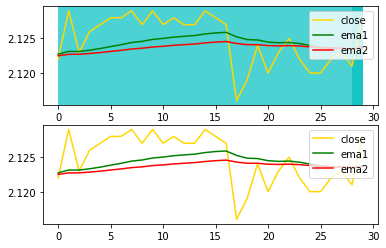

In [4]:
import numpy as np
import pandas as pd
from keras.models import load_model
from matplotlib import pyplot as plt
import os
from Funcs_CNN4 import ema_cross
import sys
np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


dir = './ohlcv/'
ohlcv_list = os.listdir(dir)

if __name__ == '__main__':

    #           PARAMS           #
    input_data_length = 30
    model_num = '66'
    crop_size = input_data_length

    #       Make folder      #
    folder_name_list = ['pred_ohlcv', 'Figure_pred']

    for folder_name in folder_name_list:
        try:
            os.mkdir('./%s/%s_%s/' % (folder_name, input_data_length, model_num))

        except Exception as e:
            print(e)
            continue

    except_list = os.listdir('./pred_ohlcv/%s_%s' % (input_data_length, model_num))

#     ohlcv_list = ['2020-01-10 BTC ohlcv.xlsx']

    #       LOAD MODEL      #
    model = load_model('./model/rapid_ascending %s_%s_cross.hdf5' % (input_data_length, model_num))

    for file in ohlcv_list:

        #         if file in except_list:
        #             continue

        print('loading %s' % file)

        Date = file.split()[0]
        Coin = file.split()[1].split('.')[0]

        try:
            X_test = np.load('./Made_Chart_to_np/%s_%s/%s %s.npy' % (input_data_length, model_num,
                                                                          Date, Coin)).astype(np.float32) / 255.
            # X_test = X_test[:100]
            print(X_test.shape)
            # quit()

            row = X_test.shape[1]
            col = X_test.shape[2]

        except Exception as e:
            print('Error in getting data from made_x :', e)
            continue

        if X_test is not None:
            if len(X_test) != 0:

                Y_pred_ = model.predict(X_test, verbose=1)
                #
                max_value = np.max(Y_pred_, axis=0)
                # print(max_value)
                # print(Y_pred_)
                Y_pred = np.argmax(Y_pred_, axis=1)

                # Y_pred = np.zeros(len(Y_pred_))
                # for i in range(len(Y_pred_)):
                #     if Y_pred_[i][1] > 0.7:
                #         Y_pred[i] = 1.
                #     else:
                #         Y_pred[i] = 0.

                ohlcv_excel = pd.read_excel('./ohlcv/%s %s ohlcv.xlsx' % (Date, Coin), index_col=0)
                ema_cross(ohlcv_excel)
                trade_state = [0] * len(ohlcv_excel)
                for i in range(2, len(ohlcv_excel)):
                    #   이전에 역순이 존재하고 바로 전이 정순이면,
                    if ohlcv_excel['EMA_1'][i - 2] <= ohlcv_excel['EMA_2'][i - 2]:
                        if ohlcv_excel['EMA_1'][i - 1] > ohlcv_excel['EMA_2'][i - 1]:
                            trade_state[i] = 1

                    if ohlcv_excel['EMA_1'][i - 2] >= ohlcv_excel['EMA_2'][i - 2]:
                        if ohlcv_excel['EMA_1'][i - 1] < ohlcv_excel['EMA_2'][i - 1]:
                            trade_state[i] = 2
                ohlcv_excel['trade_state'] = trade_state
                ohlcv_data = ohlcv_excel.values[sum(ohlcv_excel.EMA_2.isna()):].astype(np.float)[crop_size:]
                y = ohlcv_data[:, [-1]]
                span_list = list()
                crop_span = np.full(len(y), np.NaN)
                for i in range(len(crop_span)):
                    if 0.5 < y[i] < 1.5:  # 1을 찾았을 때
                        for j in range(i + 1, len(crop_span)):
                            if 1.5 < y[j] < 2.5:  # 뒤에 2가 존재한다면,
                                #   i + 1 부터 j + 1 까지 0의 값을 부여한다.
                                # print(i, j)
                                # crop_span[i + 1:j + 2] = 0
                                span_list.append(ohlcv_data[i + 1:j + 2])
                                # plt.plot(ohlcv_data[i + 1:j + 2, [1]])
                                # plt.plot(ohlcv_data[i + 1:j + 2, [5]], 'g')
                                # plt.plot(ohlcv_data[i + 1:j + 2, [6]], 'r')
                                # plt.show()
                                # plt.close()
                                break

                len_cnt = 0
                for i in range(len(span_list)):

                    ohlcv_data = span_list[i]

                    spanlist_low = []
                    spanlist_high = []

                    Y_pred_span = Y_pred[len_cnt:len_cnt + len(ohlcv_data)]
#                     print(Y_pred_span)

                    len_cnt = len_cnt + len(ohlcv_data)

                    for m in range(len(Y_pred_span)):
                        if Y_pred_span[m] == 0.:
                            if m + 1 < len(Y_pred_span):
                                spanlist_low.append((m, m + 1))
                            else:
                                spanlist_low.append((m - 1, m))

                    for m in range(len(Y_pred_span)):
                        if Y_pred_span[m] == 1.:
                            if m + 1 < len(Y_pred_span):
                                spanlist_high.append((m, m + 1))
                            else:
                                spanlist_high.append((m - 1, m))

                    # print(spanlist_low)
                    # print(spanlist_high)

                    plt.subplot(211)
                    # plt.subplot(313)
                    plt.plot((ohlcv_data[:, [1]]), 'gold', label='close')
                    plt.plot((ohlcv_data[:, [5]]), 'g', label='ema1')
                    plt.plot((ohlcv_data[:, [6]]), 'r', label='ema2')
                    plt.legend(loc='upper right')
                    for j in range(len(spanlist_low)):
                        plt.axvspan(spanlist_low[j][0], spanlist_low[j][1], facecolor='c', alpha=0.7)

                    plt.subplot(212)
                    # plt.subplot(313)
                    plt.plot((ohlcv_data[:, [1]]), 'gold', label='close')
                    plt.plot((ohlcv_data[:, [5]]), 'g', label='ema1')
                    plt.plot((ohlcv_data[:, [6]]), 'r', label='ema2')
                    plt.legend(loc='upper right')
                    for j in range(len(spanlist_high)):
                        plt.axvspan(spanlist_high[j][0], spanlist_high[j][1], facecolor='m', alpha=0.7)

                    plt.savefig('./Figure_pred/%s_%s/%s %s_%s.png' % (input_data_length, model_num, Date, Coin, i), dpi=500)
                    plt.close()





